# Ocena jakości wina Vinho Verde

Celem zadania jest ocena jakości wina.

Uwzględniono dwa zbiory danych dotyczące próbek czerwonego wina Vinho Verde z północy Portugalii.

Źródło: 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

- 1600 obserwacji z 11 zmiennymi wejściowymi i jedną zmienną wyjściową.
- Zmienne opisują:
  1. Stałą kwasowość.
  2. Kwasowość lotną.
  3. Kwas cytrynowy.
  4. Cukier resztkowy.
  5. Chlorki.
  6. Wolny dwutlenek siarki.
  7. Całkowity dwutlenek siarki.
  8. Gęstość.
  9. pH.
  10. Siarczany.
  11. Alkohol.
  12. Jakość (ocena od 0 do 10).

[Dane](https://github.com/UEPP40/PUM/blob/c1ab27e52bc82cc151bb217b27bd25dfd057d9e8/winequality-red.csv)


# Import bibliotek, pliku csv oraz wstępny przegląd danych

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib as hl
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [2]:
# Wczytanie danych z pliku CSV do ramki danych
wineDataFrame = pd.read_csv('winequality-red.csv', sep=";")

# Wyświetlenie pierwszych 5 rekordów wraz z podstawowymi informacjami o danych
print("Pierwsze 5 rekordów zbioru danych:")
print(wineDataFrame.head(5))

print("\nInformacje o zbiorze danych:")
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

print("\nStatystyki opisowe zbioru danych:")
# Wyświetlenie statystyk opisowych zbioru danych
print(wineDataFrame.describe())

Pierwsze 5 rekordów zbioru danych:
   fixed acidity  volatile acidity citric acid residual sugar chlorides  \
0            7.4              0.70           0            1.9     0.076   
1            7.8              0.88           0            2.6     0.098   
2            7.8              0.76        0.04            2.3     0.092   
3           11.2              0.28        0.56            1.9     0.075   
4            7.4              0.70           0            1.9     0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2  

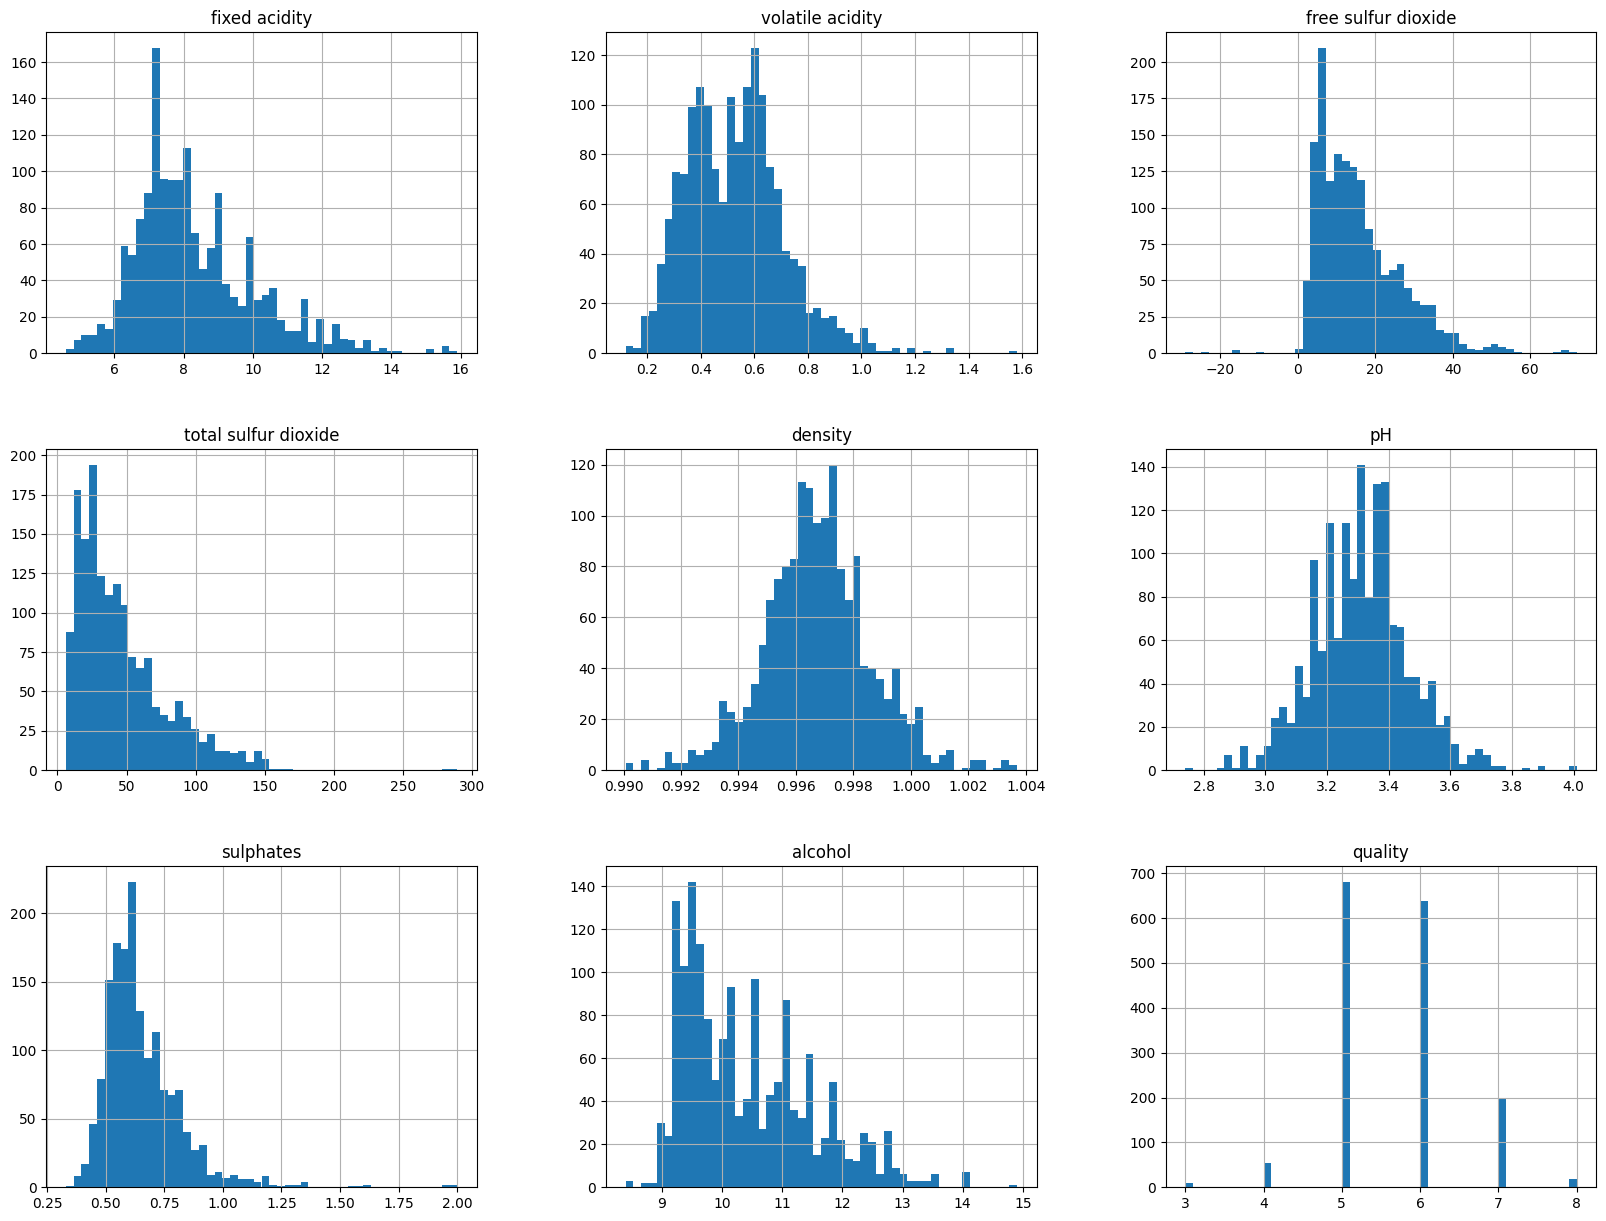

In [3]:
# Narysowanie histogramów dla wszystkich zmiennych oraz kilku innych przydatnych wykresów
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

# Czyszczenie danych

In [4]:
# usuń zbędne znaki (nie będące Ascii)
for column in wineDataFrame.columns:
    wineDataFrame[column] = wineDataFrame[column].astype(str).str.replace(r'[^\x00-\x7F]+', '', regex=True)
# zmien typ zmiennych ilościowych
for column in wineDataFrame.columns:
    wineDataFrame[column] = pd.to_numeric(wineDataFrame[column], errors='coerce')
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1596 non-null   float64
 3   residual sugar        1598 non-null   float64
 4   chlorides             1596 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1595 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [5]:
# Usuń wiersze z duplikatami
wineDataFrame.drop_duplicates(inplace=True)

# # zastąpienie psutych medianami
wineDataFrame.fillna(wineDataFrame.median(), inplace=True)

# Display basic information about the data set
print(wineDataFrame.info())
print(wineDataFrame.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1588 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1588 non-null   float64
 1   volatile acidity      1588 non-null   float64
 2   citric acid           1588 non-null   float64
 3   residual sugar        1588 non-null   float64
 4   chlorides             1588 non-null   float64
 5   free sulfur dioxide   1588 non-null   float64
 6   total sulfur dioxide  1588 non-null   float64
 7   density               1588 non-null   float64
 8   pH                    1588 non-null   float64
 9   sulphates             1588 non-null   float64
 10  alcohol               1588 non-null   float64
 11  quality               1588 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 161.3 KB
None
(1588, 12)


In [6]:
# print empty values
print(wineDataFrame.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# usunięcie rekorów z wartościami wyraźnie odstającymi
for column in wineDataFrame.columns:
    if column != 'quality' and pd.api.types.is_numeric_dtype(wineDataFrame[column]):
        Q1 = wineDataFrame[column].quantile(0.10)
        Q3 = wineDataFrame[column].quantile(0.90)
        IQR = Q3 - Q1

        filter = (wineDataFrame[column] >= Q1 - 1.5 * IQR) & (wineDataFrame[column] <= Q3 + 1.5 * IQR)
        wineDataFrame = wineDataFrame.loc[filter]

# Display basic information about the data set
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1503 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1503 non-null   float64
 1   volatile acidity      1503 non-null   float64
 2   citric acid           1503 non-null   float64
 3   residual sugar        1503 non-null   float64
 4   chlorides             1503 non-null   float64
 5   free sulfur dioxide   1503 non-null   float64
 6   total sulfur dioxide  1503 non-null   float64
 7   density               1503 non-null   float64
 8   pH                    1503 non-null   float64
 9   sulphates             1503 non-null   float64
 10  alcohol               1503 non-null   float64
 11  quality               1503 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 152.6 KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 1503 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1503 non-null   float64
 1   volatile acidity      1503 non-null   float64
 2   citric acid           1503 non-null   float64
 3   residual sugar        1503 non-null   float64
 4   chlorides             1503 non-null   float64
 5   free sulfur dioxide   1503 non-null   float64
 6   total sulfur dioxide  1503 non-null   float64
 7   density               1503 non-null   float64
 8   pH                    1503 non-null   float64
 9   sulphates             1503 non-null   float64
 10  alcohol               1503 non-null   float64
 11  quality               1503 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 152.6 KB
None


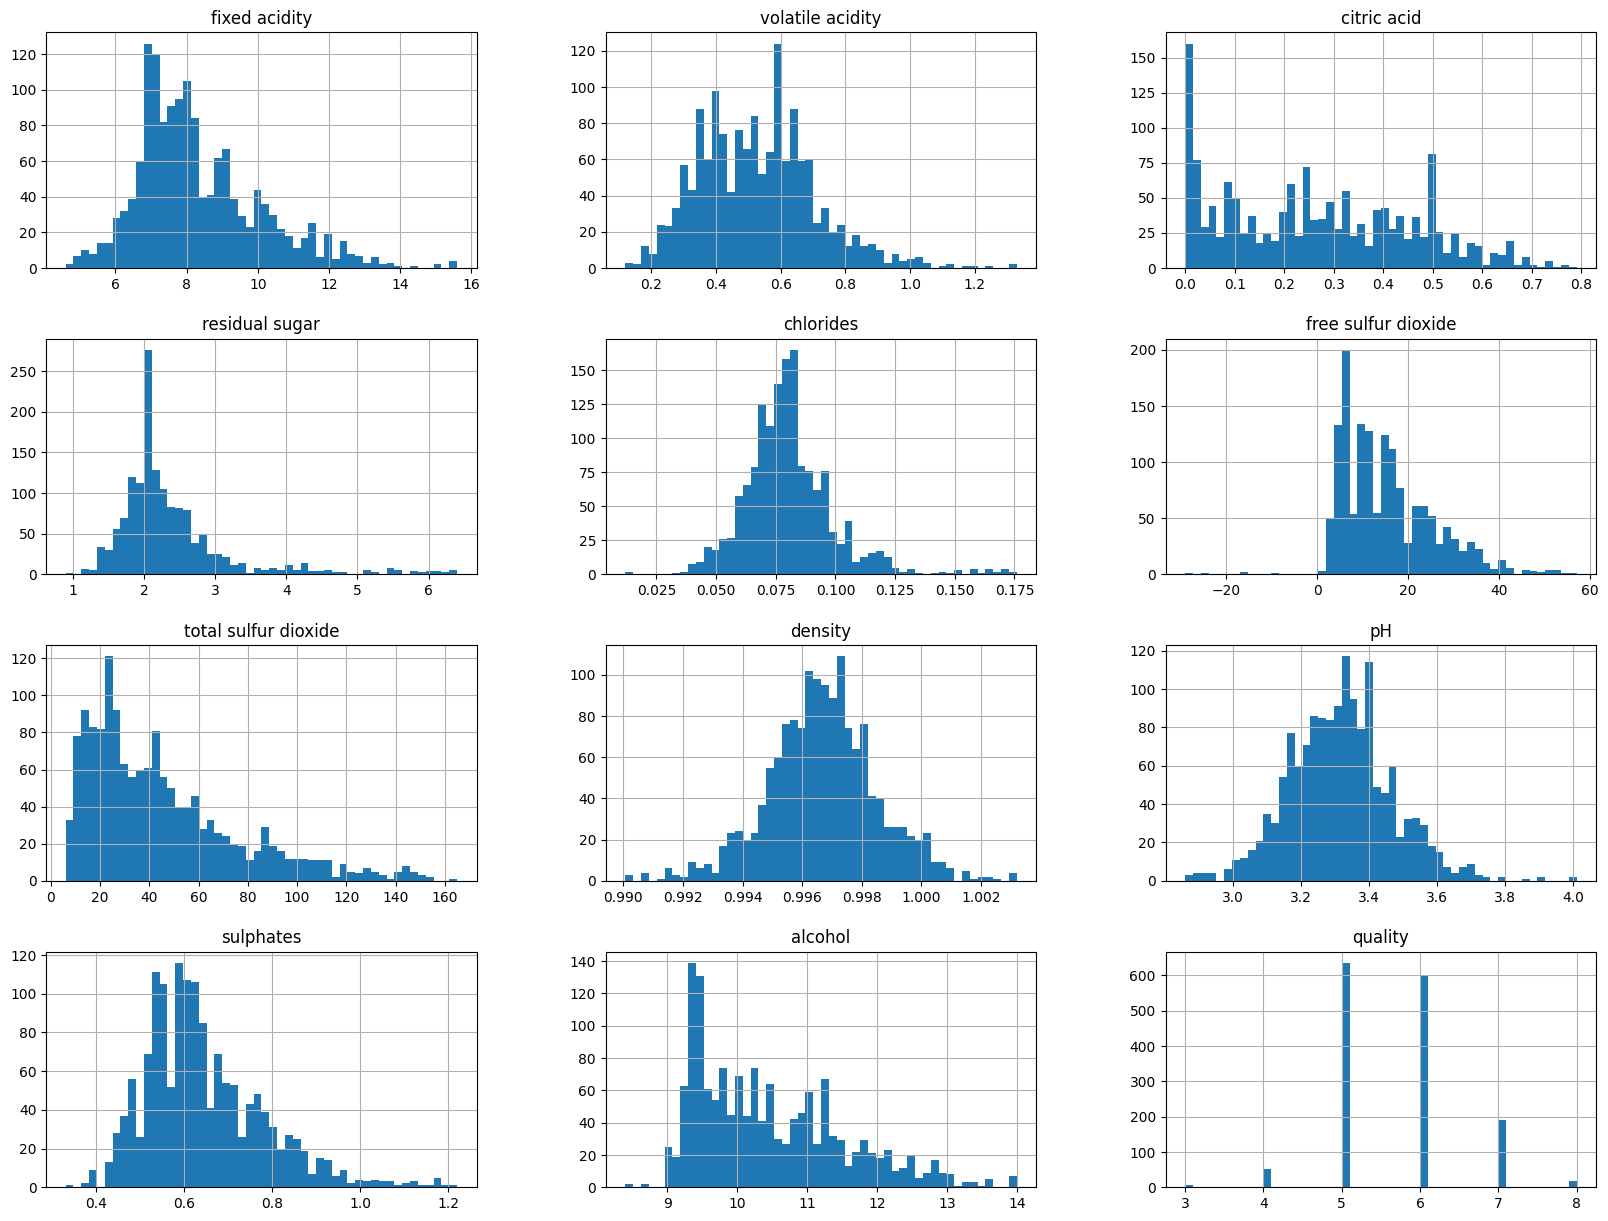

In [8]:
# Display basic information about the data set
print(wineDataFrame.info())
# plot histogram
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
# # stwórz obiekt enkodera dla kolumn o typie obiektowym
# le = LabelEncoder()
# for column in wineDataFrame.columns:
#     if pd.api.types.is_object_dtype(wineDataFrame[column]):
#         wineDataFrame[column] = le.fit_transform(wineDataFrame[column])
# # sprawdź transformacje
# wineDataFrame.head()

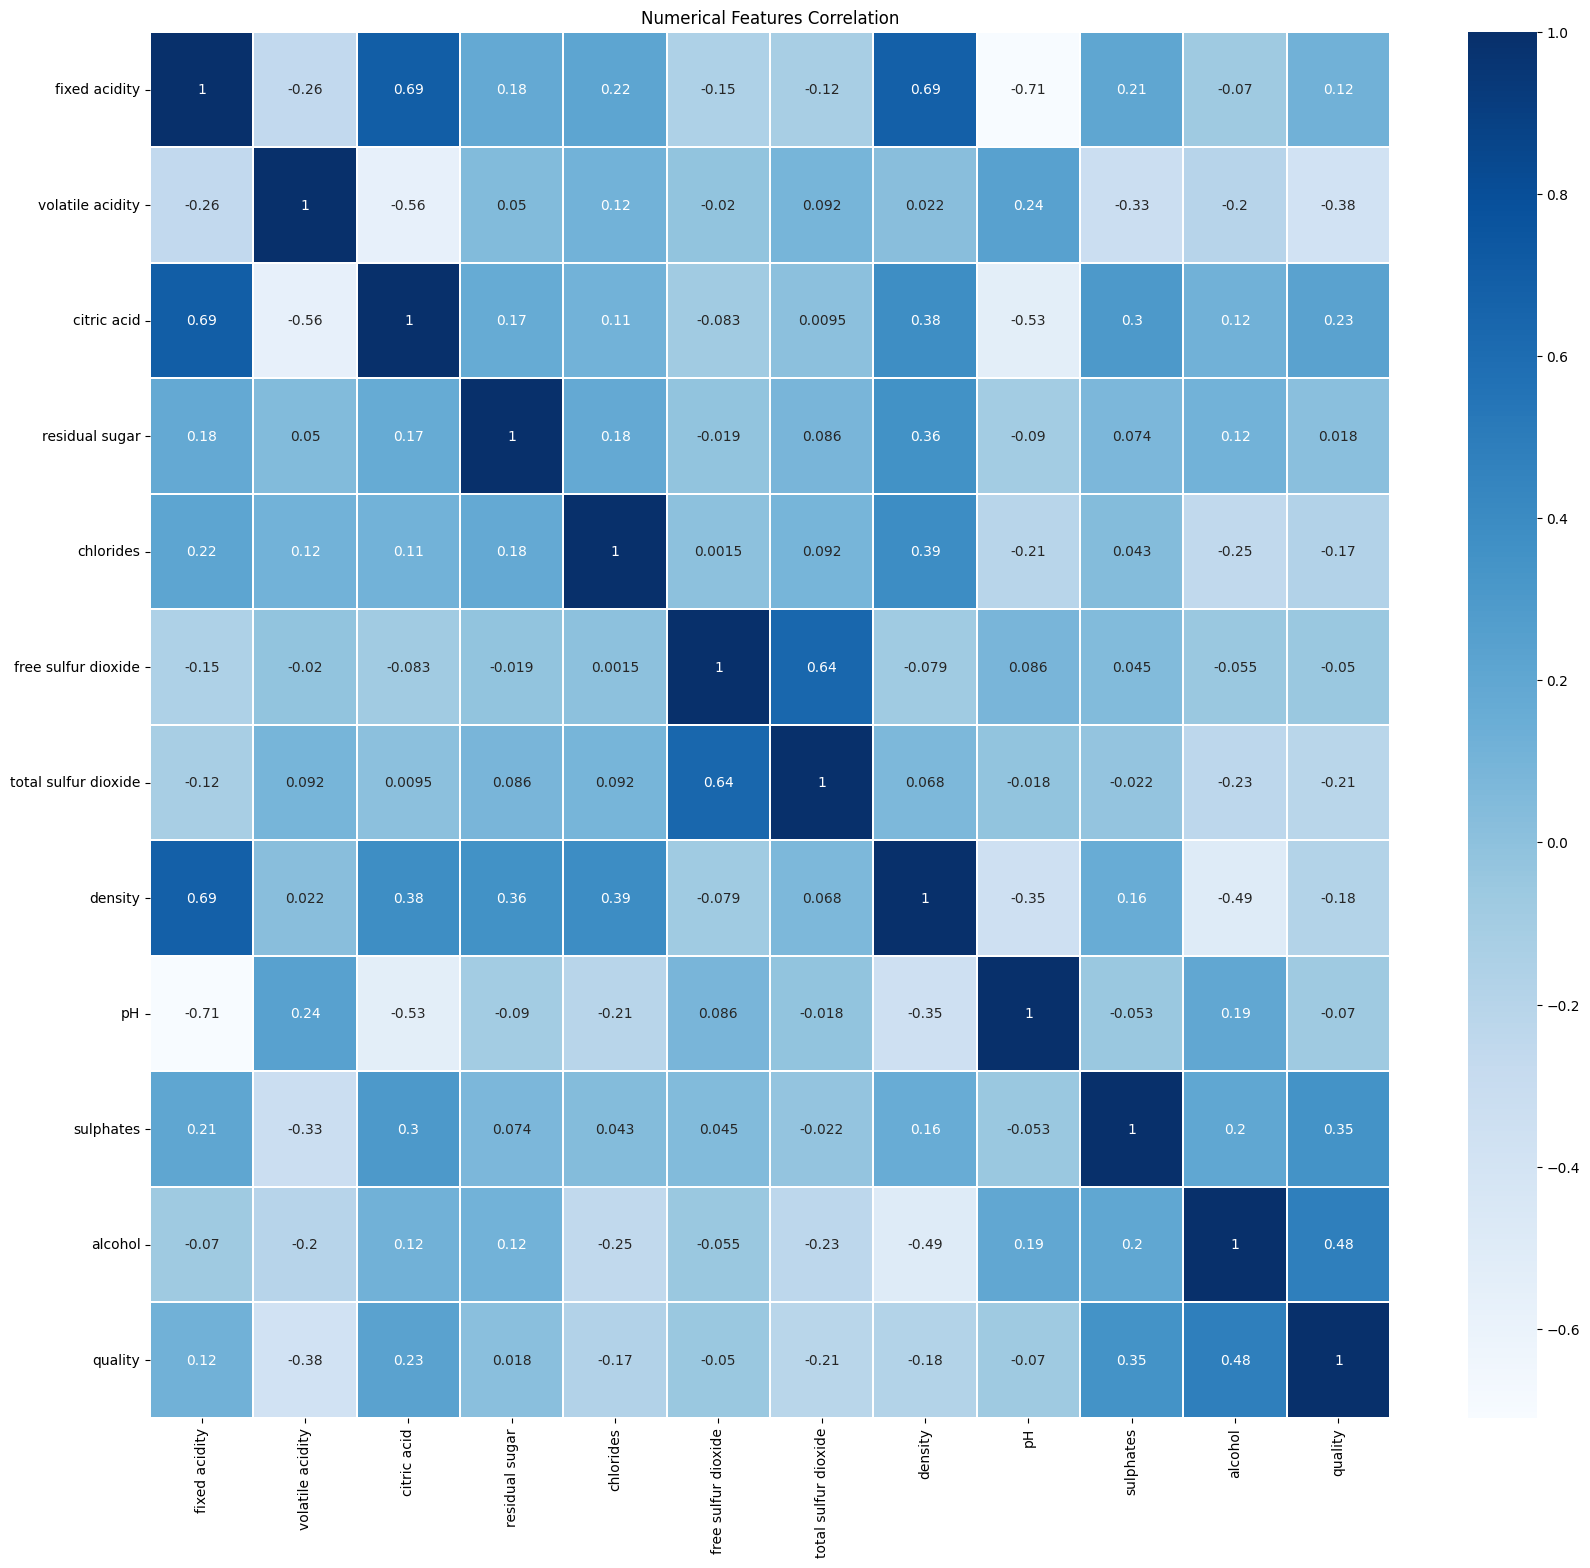

In [10]:
# wskaż korelacje
plt.figure(figsize = (20, 18)) 
# creating the correlation heatmap
sns.heatmap(wineDataFrame.corr(), annot = True, linewidths = 0.1, cmap = 'Blues')
plt.title('Numerical Features Correlation')
plt.show()

In [11]:
corr_matrix = wineDataFrame.corr()
cor_target = abs(corr_matrix["quality"])
relevant_features = cor_target[cor_target>0.1]

# print which features are relevant
print("Relevant features (correlation with 'quality' > 0.1):\n", relevant_features)

# and which are not
print("\nNon-relevant features (correlation with 'quality' <= 0.1):\n", cor_target[cor_target<=0.1])

wineDataFrame = wineDataFrame[relevant_features.index]

Relevant features (correlation with 'quality' > 0.1):
 fixed acidity           0.124861
volatile acidity        0.382405
citric acid             0.234035
chlorides               0.174600
total sulfur dioxide    0.210503
density                 0.181045
sulphates               0.350524
alcohol                 0.481324
quality                 1.000000
Name: quality, dtype: float64

Non-relevant features (correlation with 'quality' <= 0.1):
 residual sugar         0.017807
free sulfur dioxide    0.049711
pH                     0.069686
Name: quality, dtype: float64


In [12]:
wineDataFrame.head(5)

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,5
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,5
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,6
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5


In [13]:
wineData = wineDataFrame.drop(columns=["quality"])
wineRatings = wineDataFrame["quality"]
wineData.to_csv('wineData.csv', index=False)
wineRatings.to_csv('wineRatings.csv', index=False)

# Podział danych na zbiory treningowe i testowe (blokowanie walidacji krzyżowej do wywalenia)

In [14]:
# Podziel dane na zbiór uczący i testowy
X = wineDataFrame.drop(columns=["quality"])
y = wineDataFrame["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Rozmiar zbioru treningowego:", len(X_train))
print("Rozmiar zbioru testowego:", len(X_test))

Rozmiar zbioru treningowego: 1052
Rozmiar zbioru testowego: 451


In [15]:
# Display the data splits
print("Training data (features):")
print(X_train.head())
print("\nTest data (features):")
print(X_test.head())
print("\nTraining data (target):")
print(y_train.head())
print("\nTest data (target):")
print(y_test.head())

Training data (features):
      fixed acidity  volatile acidity  citric acid  chlorides  \
1268            6.9              0.41         0.31      0.079   
1432            5.9              0.44         0.00      0.042   
1355            6.1              0.32         0.25      0.086   
573            10.5              0.59         0.49      0.070   
220             7.8              0.34         0.37      0.082   

      total sulfur dioxide  density  sulphates  alcohol  
1268                  51.0  0.99668       0.55      9.5  
1432                  11.0  0.99440       0.85     11.7  
1355                  32.0  0.99464       0.44     10.1  
573                   47.0  0.99910       0.56      9.6  
220                   58.0  0.99640       0.59      9.4  

Test data (features):
      fixed acidity  volatile acidity  citric acid  chlorides  \
58              7.8              0.59         0.18      0.076   
1552            6.3              0.68         0.01      0.103   
205            12

In [16]:
# Eksport przygotowanych danych do plików CSV
# Zbiór uczący
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
# Zbiór testowy
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
